# NN_Polar_Decoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import gc
gc.collect(generation=2)

196

### Define Noise & Modulator

In [2]:
def BPSK_modulator(x):
    return -2*x +1

In [3]:
def qpsk_NRZ_encoder(x):
    half_CWs = int(x.shape[1]/2)    # half codewords length
    for i in range(x.shape[0]):     # batch_size
        for j in range(half_CWs):
            if (x[i,j] == x[i,j+half_CWs]):  # 00 & 11 -> -2*x +1
                x[i,j] = (-2*x[i,j]) +1
                x[i,j+half_CWs] = (-2*x[i,j+half_CWs]) +1      
            if (x[i,j] != x[i,j+half_CWs]):  # 01 & 10 -> 2*x -1
                x[i,j] = (2*x[i,j]) -1
                x[i,j+half_CWs] = (2*x[i,j+half_CWs]) -1     
    return x/np.sqrt(2)

In [4]:
def QPSK_modulator(x):
    # X = after polar encoding (256,16)
    # QPSK step : 
    # First : 把實部虛部分開，並把虛部丟在實部後面
    real = []
    imag = []
    stack = []
    for n in range(x.shape[0]):  # batch-size
        for m in range(0, x.shape[1], 2): 
            stack.append(x[n,m])  # real-part
        real.append(stack)
        stack = []
        for m in range(1, x.shape[1], 2): 
            stack.append(x[n,m])  # imag-part
        imag.append(stack)
        stack = []
    symbol_np = np.hstack((real, imag))
    # Second : NRZ-encoding (0 -> +1 ; 1 -> -1)
    # symbol_nrz = (-2*symbol_np +1)/np.sqrt(2)
    symbol_nrz = qpsk_NRZ_encoder(symbol_np)
    return symbol_nrz

In [5]:
def AWGN_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                   # real-part
            y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)   # imag-part
    return y

In [6]:
def FineTuning_addNoise(x, awgn_power):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        real_add_impulse = np.random.randint(low=0, high=sym_num)
        for j in range (sym_num):      # no_of_bits
            if (j == real_add_impulse) :
                IGR = 100              # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)                  # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)  # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)                     # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)     # imag-part
    return y

In [7]:
def Test_addNoise(x, awgn_power, impulse_prob):
    sym_num = int(x.shape[1]/2)
    y = np.zeros((x.shape[0],x.shape[1]))
    for i in range (x.shape[0]):       # batch-size
        for j in range (sym_num):      # no_of_bits
            dice = np.random.uniform(0,1)   # 0~1 隨機選一個小數
            if dice <= prob :
                IGR = 100              # 高斯脈衝能量比
                impulse_power = awgn_power * IGR
                y[i,j] = x[i,j] + np.sqrt(impulse_power/2) * np.random.normal(0,1)           # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(impulse_power/2) * np.random.normal(0,1)   # imag-part
            else : 
                y[i,j] = x[i,j] + np.sqrt(awgn_power/2) * np.random.normal(0,1)              # real-part
                y[i,j+sym_num] = x[i,j+sym_num] + np.sqrt(awgn_power/2) * np.random.normal(0,1)      # imag-part
    return y

### Polar Encoder (Bhattacharyya)

In [8]:
"""
    Algorithm : The Bhattacharyya bounds
"""
def polarization_channel_awgn(N, k, design_snr_dB=0):  
    design_snr_dB = design_snr_dB +10*np.log10(k/N)
    S = 10**(design_snr_dB/10)       # S : R*Eb/N0
    n = np.log2(N)                   # N = 2^n
    z0 = np.zeros(N)                 # N : Codewords length
    # initial the Bhattacharyya parameter of BI-AWGN channel,be replaced with exp(−R*Eb/N0)
    z0[0] = np.exp(-S)               # initial erasure-probability of channel        
    for j in range(1,int(n)+1):      # How many stage to polarization (output-to-input)
        u = 2**j                     # 2^n = N = 幾個 W 副本通道
        for t in range(0,int(u/2)):  # For each connection
            T = z0[t]
            z0[t] = 2*T - T**2       # upper channel (+ channel)
            z0[int(u/2)+t] = T**2    # lower channel (- channel)
    # sort into increasing order
    # z0 array 裝的是每個分離通道的 Prob.Error 數值，
    # 數值越大代表通道越糟
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    idx = np.argsort(z0)             
    # argsort() 返回的是數組值從小到大的索引值
    #====> 通道由最好排到最差 (左[0]->右[N]) <====#
    # select k best channels
    # 選最好的前半部分通道做 bit-reversal
    ######### idx = np.sort(bitrevorder(idx[0:k]))
    A = np.zeros(N, dtype=bool)
    A[idx[0:k]] = True   # 將 Good_channel 設為可傳 info.
    # idx 為 " 好的通道 " bit-reversal 後的新通道
    return A

def polar_xor_encoding(u):  
    # 每一組 codewords 為 16-bits , 共 256 組
    N = len(u)   # 只看第一維 N = 2**k
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)   # 通道共分裂成幾階
    for s in range(0,stages):         # s = stage
        i = 0                         # i = no.of samples
        while i < N:                  # N = 256            
            for j in range(0,n):      # j always = 0
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]  # XOR : Good Channel
            i=i+2*n
        n=2*n
    return x

### Build Torch NN Training Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
k = 11                        # number of information bits
N = 64                        # code length (After Encoder data size)  
R = k/N

In [11]:
class DNN_Model(nn.Module):
    def __init__(self):
        super(DNN_Model, self).__init__()
        self.fcnn1 = nn.Linear(N, 1500)                  # 第1層 Linear NN
        self.fcnn2 = nn.Linear(1500, 1500)                # 第2層 Linear NN
        self.fcnn3 = nn.Linear(1500, 1200)                 # 第3層 Linear NN
        self.fcnn4 = nn.Linear(1200, 1000)                 # 第3層 Linear NN
        self.output = nn.Linear(1000, k)                  # 第4層 Linear NN
        # nn.init.kaiming_normal_(self.fcnn2.weight, mode='fan_in')     
        # nn.init.normal_(self.fcnn4.bias, mean=0.0, std=0.1)

    def forward(self, input_layer):
        x = F.relu(self.fcnn1(input_layer))
        x = F.relu(self.fcnn2(x))
        x = F.relu(self.fcnn3(x))
        x = F.relu(self.fcnn4(x))
        predi_output = torch.sigmoid(self.output(x))
        return predi_output
        
decoder = DNN_Model()                      # build the DNN Model
print("**decoder_model:",decoder)          # 將模型print

**decoder_model: DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)


### Loss Function Tensor to String Transfer

In [12]:
import numpy as np
import re

In [13]:
err_tensor_str = ""

In [14]:
err_num = re.findall(r"\d+\.?\d*",err_tensor_str)
float_err_num = list(map(float, err_num))
clip_0 = []
# print(float_err_num)
for i in range(0, len(float_err_num), 2):
    clip_0.append(float_err_num[i])
print(clip_0)

[]


### Plot Loss Function

In [15]:
# n = np.linspace(0, 2001, 1804)

In [16]:
"""
# No Smoothing :
total_hist_loss = awgn_1 + awgn_2 + impulse_1 + impulse_2
plt.plot(total_hist_loss)
plt.title('Model loss', fontsize=17)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Fine-Tuning Training-Loss'], fontsize=15)
plt.grid(True, which="both")
plt.rcParams['figure.figsize'] = (9, 6)
plt.show()
"""

'\n# No Smoothing :\ntotal_hist_loss = awgn_1 + awgn_2 + impulse_1 + impulse_2\nplt.plot(total_hist_loss)\nplt.title(\'Model loss\', fontsize=17)\nplt.ylabel(\'Loss\', fontsize=15)\nplt.xlabel(\'Epoch\', fontsize=15)\nplt.legend([\'Fine-Tuning Training-Loss\'], fontsize=15)\nplt.grid(True, which="both")\nplt.rcParams[\'figure.figsize\'] = (9, 6)\nplt.show()\n'

In [17]:
"""
def smooth_curve(points, factor=0.995):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
"""

'\ndef smooth_curve(points, factor=0.995):\n    smoothed_points = []\n    for point in points:\n        if smoothed_points:\n            previous = smoothed_points[-1]\n            smoothed_points.append(previous * factor + point * (1 - factor))\n        else:\n            smoothed_points.append(point)\n    return smoothed_points\n'

In [18]:
"""
# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)
np_hist = np.array(total_hist_loss)
loss = smooth_curve(np_hist)
plt.plot(loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True, which="both")
plt.show()
"""

'\n# when plotting, smooth out the points by some factor (0.5 = rough, 0.99 = smooth)\nnp_hist = np.array(total_hist_loss)\nloss = smooth_curve(np_hist)\nplt.plot(loss)\nplt.title(\'Model loss\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Epoch\')\nplt.legend([\'Train\', \'Test\'])\nplt.grid(True, which="both")\nplt.show()\n'

### Test NN Decoder

In [19]:
## load model weights
decoder.load_state_dict(torch.load('FT_4-layerNN_V9__2-dB.pt'))
decoder.eval()

DNN_Model(
  (fcnn1): Linear(in_features=64, out_features=1500, bias=True)
  (fcnn2): Linear(in_features=1500, out_features=1500, bias=True)
  (fcnn3): Linear(in_features=1500, out_features=1200, bias=True)
  (fcnn4): Linear(in_features=1200, out_features=1000, bias=True)
  (output): Linear(in_features=1000, out_features=11, bias=True)
)

In [20]:
k = 11                        # number of information bits
N = 64                        # code length (After Encoder data size)  
R = k/N
num_words = 1000              # multiple of test_batch
test_batch = 1 

In [21]:
# define test SNR & noise power
test_SNR_dB = np.arange(0, 6, 1)
test_noise_power = 1/10**(test_SNR_dB/10) 
test_noise_power = test_noise_power * 2
print("test_noise_power:", test_noise_power)    # 1/2*No
print("test_noise_sigma:", np.sqrt(test_noise_power/2))

test_noise_power: [2.         1.58865647 1.26191469 1.00237447 0.79621434 0.63245553]
test_noise_sigma: [1.         0.89125094 0.79432823 0.70794578 0.63095734 0.56234133]


In [22]:
# Polar Code Channel Polarization
A = polarization_channel_awgn(N, k, design_snr_dB = 0)  

In [23]:
impulse_probs = [0.03]   # 2/64 = 0.03
print("**impulse_probs:",impulse_probs,"**")
nb_errors = np.zeros((len(impulse_probs),len(test_noise_power)))
nb_bits = np.zeros((len(impulse_probs),len(test_noise_power)))
#sigma_with_impulse_table = np.zeros((len(impulse_probs),len(sigmas)))
print("-------------------------------------------------------------------------------------------")

for s in range(0,len(test_noise_power)):   # SNR_dB
    for p in range(0,len(impulse_probs)):  # impulse_prob   
        print("================= AWGN_SNR:",test_SNR_dB[s]," dB, (with impulse_prob=",impulse_probs[p],") =================")
        wrong_bits = 0
        Error_counter = 0
        while (nb_errors[p,s] <= 5500 and Error_counter <= 1100):  # Error control Threshold
            Error_counter = Error_counter +1
            print("# Error_counter:", Error_counter)
            for ii in range(1, np.round(num_words/test_batch).astype(int)+1):  # each batchs
                # print("**No_of_batch:",ii,"**")
                ## np.round ()平均舍入到給定的小數位數 = 四捨五入取整數。
                ## Source (only information-bits)
                d_test_info = np.random.binomial(n=1, p=0.5, size=(test_batch, k))
                ## d_test_info = np.random.randint(0, 2, size=(test_batch, k))
            #======================================= Polar Encoder ===========================================#
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,A] = d_test_info
                for iii in range(0,test_batch):
                    x_test[iii] = polar_xor_encoding(u_test[iii])
                x_test = x_test.astype(int)
            #========================================== Modulator ============================================#
                ## m_test = -2*x_test +1                  # Modulator (BPSK)
                m_test = QPSK_modulator(x_test)          # Modulator (QPSK)
            #================================= Channel (AWGN + Impulse) ======================================#
                ## y_test = Test_addNoise(x=m_test, awgn_power=test_noise_power[s], impulse_prob=impulse_probs[p]
                y_test = FineTuning_addNoise(x=m_test, awgn_power=test_noise_power[s])
                ## y_test = AWGN_addNoise(x=m_test, awgn_power=test_noise_power[s])
            #==================================== Decoder predict output =====================================#
                predi_out = decoder(torch.tensor(y_test).float())
                predi_out = predi_out.detach().numpy()
                pred_desicion = np.round(predi_out)
                # print("**pred_desicion:", pred_desicion)
                # print("**d_test_info  :", d_test_info)
                wrong_bits = np.sum(np.not_equal(pred_desicion, d_test_info))
                # print("**Word_wrong_bits:", wrong_bits)
                nb_errors[p,s] += wrong_bits
                # print("**Cumulative_error_bits:", nb_errors[p,s])
                nb_bits[p,s] += d_test_info.size
                # print("**Cumulative_total_bits:", nb_bits[p,s], "**")
                # print("--------------------------------------------------------------------------")
                if (nb_errors[p,s] > 5500): break   # if batch_sum_errors > 5500 : leave loop
            print("**Cumulative_error_bits:", nb_errors[p,s])
            print("**Cumulative_total_bits:", nb_bits[p,s], "**")
            print("--------------------------------------------------------------------------")
            continue   # if error bits not enough: keep decoding

**impulse_probs: [0.03] **
-------------------------------------------------------------------------------------------
================= AWGN_SNR: 0  dB, (with impulse_prob= 0.03 ) =================
# Error_counter: 1
**Cumulative_error_bits: 534.0
**Cumulative_total_bits: 11000.0 **
--------------------------------------------------------------------------
# Error_counter: 2
**Cumulative_error_bits: 1040.0
**Cumulative_total_bits: 22000.0 **
--------------------------------------------------------------------------
# Error_counter: 3
**Cumulative_error_bits: 1598.0
**Cumulative_total_bits: 33000.0 **
--------------------------------------------------------------------------
# Error_counter: 4
**Cumulative_error_bits: 2167.0
**Cumulative_total_bits: 44000.0 **
--------------------------------------------------------------------------
# Error_counter: 5
**Cumulative_error_bits: 2752.0
**Cumulative_total_bits: 55000.0 **
-------------------------------------------------------------------

**Cumulative_error_bits: 2050.0
**Cumulative_total_bits: 209000.0 **
--------------------------------------------------------------------------
# Error_counter: 20
**Cumulative_error_bits: 2117.0
**Cumulative_total_bits: 220000.0 **
--------------------------------------------------------------------------
# Error_counter: 21
**Cumulative_error_bits: 2227.0
**Cumulative_total_bits: 231000.0 **
--------------------------------------------------------------------------
# Error_counter: 22
**Cumulative_error_bits: 2339.0
**Cumulative_total_bits: 242000.0 **
--------------------------------------------------------------------------
# Error_counter: 23
**Cumulative_error_bits: 2427.0
**Cumulative_total_bits: 253000.0 **
--------------------------------------------------------------------------
# Error_counter: 24
**Cumulative_error_bits: 2534.0
**Cumulative_total_bits: 264000.0 **
--------------------------------------------------------------------------
# Error_counter: 25
**Cumulative_err

**Cumulative_error_bits: 494.0
**Cumulative_total_bits: 176000.0 **
--------------------------------------------------------------------------
# Error_counter: 17
**Cumulative_error_bits: 541.0
**Cumulative_total_bits: 187000.0 **
--------------------------------------------------------------------------
# Error_counter: 18
**Cumulative_error_bits: 567.0
**Cumulative_total_bits: 198000.0 **
--------------------------------------------------------------------------
# Error_counter: 19
**Cumulative_error_bits: 612.0
**Cumulative_total_bits: 209000.0 **
--------------------------------------------------------------------------
# Error_counter: 20
**Cumulative_error_bits: 633.0
**Cumulative_total_bits: 220000.0 **
--------------------------------------------------------------------------
# Error_counter: 21
**Cumulative_error_bits: 665.0
**Cumulative_total_bits: 231000.0 **
--------------------------------------------------------------------------
# Error_counter: 22
**Cumulative_error_bit

**Cumulative_error_bits: 2338.0
**Cumulative_total_bits: 737000.0 **
--------------------------------------------------------------------------
# Error_counter: 68
**Cumulative_error_bits: 2363.0
**Cumulative_total_bits: 748000.0 **
--------------------------------------------------------------------------
# Error_counter: 69
**Cumulative_error_bits: 2407.0
**Cumulative_total_bits: 759000.0 **
--------------------------------------------------------------------------
# Error_counter: 70
**Cumulative_error_bits: 2467.0
**Cumulative_total_bits: 770000.0 **
--------------------------------------------------------------------------
# Error_counter: 71
**Cumulative_error_bits: 2506.0
**Cumulative_total_bits: 781000.0 **
--------------------------------------------------------------------------
# Error_counter: 72
**Cumulative_error_bits: 2549.0
**Cumulative_total_bits: 792000.0 **
--------------------------------------------------------------------------
# Error_counter: 73
**Cumulative_err

**Cumulative_error_bits: 4037.0
**Cumulative_total_bits: 1287000.0 **
--------------------------------------------------------------------------
# Error_counter: 118
**Cumulative_error_bits: 4074.0
**Cumulative_total_bits: 1298000.0 **
--------------------------------------------------------------------------
# Error_counter: 119
**Cumulative_error_bits: 4120.0
**Cumulative_total_bits: 1309000.0 **
--------------------------------------------------------------------------
# Error_counter: 120
**Cumulative_error_bits: 4154.0
**Cumulative_total_bits: 1320000.0 **
--------------------------------------------------------------------------
# Error_counter: 121
**Cumulative_error_bits: 4193.0
**Cumulative_total_bits: 1331000.0 **
--------------------------------------------------------------------------
# Error_counter: 122
**Cumulative_error_bits: 4220.0
**Cumulative_total_bits: 1342000.0 **
--------------------------------------------------------------------------
# Error_counter: 123
**Cu

**Cumulative_error_bits: 69.0
**Cumulative_total_bits: 88000.0 **
--------------------------------------------------------------------------
# Error_counter: 9
**Cumulative_error_bits: 79.0
**Cumulative_total_bits: 99000.0 **
--------------------------------------------------------------------------
# Error_counter: 10
**Cumulative_error_bits: 93.0
**Cumulative_total_bits: 110000.0 **
--------------------------------------------------------------------------
# Error_counter: 11
**Cumulative_error_bits: 106.0
**Cumulative_total_bits: 121000.0 **
--------------------------------------------------------------------------
# Error_counter: 12
**Cumulative_error_bits: 110.0
**Cumulative_total_bits: 132000.0 **
--------------------------------------------------------------------------
# Error_counter: 13
**Cumulative_error_bits: 128.0
**Cumulative_total_bits: 143000.0 **
--------------------------------------------------------------------------
# Error_counter: 14
**Cumulative_error_bits: 138

**Cumulative_error_bits: 559.0
**Cumulative_total_bits: 649000.0 **
--------------------------------------------------------------------------
# Error_counter: 60
**Cumulative_error_bits: 574.0
**Cumulative_total_bits: 660000.0 **
--------------------------------------------------------------------------
# Error_counter: 61
**Cumulative_error_bits: 590.0
**Cumulative_total_bits: 671000.0 **
--------------------------------------------------------------------------
# Error_counter: 62
**Cumulative_error_bits: 600.0
**Cumulative_total_bits: 682000.0 **
--------------------------------------------------------------------------
# Error_counter: 63
**Cumulative_error_bits: 610.0
**Cumulative_total_bits: 693000.0 **
--------------------------------------------------------------------------
# Error_counter: 64
**Cumulative_error_bits: 630.0
**Cumulative_total_bits: 704000.0 **
--------------------------------------------------------------------------
# Error_counter: 65
**Cumulative_error_bit

**Cumulative_error_bits: 1064.0
**Cumulative_total_bits: 1210000.0 **
--------------------------------------------------------------------------
# Error_counter: 111
**Cumulative_error_bits: 1073.0
**Cumulative_total_bits: 1221000.0 **
--------------------------------------------------------------------------
# Error_counter: 112
**Cumulative_error_bits: 1084.0
**Cumulative_total_bits: 1232000.0 **
--------------------------------------------------------------------------
# Error_counter: 113
**Cumulative_error_bits: 1092.0
**Cumulative_total_bits: 1243000.0 **
--------------------------------------------------------------------------
# Error_counter: 114
**Cumulative_error_bits: 1116.0
**Cumulative_total_bits: 1254000.0 **
--------------------------------------------------------------------------
# Error_counter: 115
**Cumulative_error_bits: 1119.0
**Cumulative_total_bits: 1265000.0 **
--------------------------------------------------------------------------
# Error_counter: 116
**Cu

**Cumulative_error_bits: 1615.0
**Cumulative_total_bits: 1760000.0 **
--------------------------------------------------------------------------
# Error_counter: 161
**Cumulative_error_bits: 1629.0
**Cumulative_total_bits: 1771000.0 **
--------------------------------------------------------------------------
# Error_counter: 162
**Cumulative_error_bits: 1640.0
**Cumulative_total_bits: 1782000.0 **
--------------------------------------------------------------------------
# Error_counter: 163
**Cumulative_error_bits: 1653.0
**Cumulative_total_bits: 1793000.0 **
--------------------------------------------------------------------------
# Error_counter: 164
**Cumulative_error_bits: 1661.0
**Cumulative_total_bits: 1804000.0 **
--------------------------------------------------------------------------
# Error_counter: 165
**Cumulative_error_bits: 1676.0
**Cumulative_total_bits: 1815000.0 **
--------------------------------------------------------------------------
# Error_counter: 166
**Cu

**Cumulative_error_bits: 2207.0
**Cumulative_total_bits: 2310000.0 **
--------------------------------------------------------------------------
# Error_counter: 211
**Cumulative_error_bits: 2209.0
**Cumulative_total_bits: 2321000.0 **
--------------------------------------------------------------------------
# Error_counter: 212
**Cumulative_error_bits: 2218.0
**Cumulative_total_bits: 2332000.0 **
--------------------------------------------------------------------------
# Error_counter: 213
**Cumulative_error_bits: 2227.0
**Cumulative_total_bits: 2343000.0 **
--------------------------------------------------------------------------
# Error_counter: 214
**Cumulative_error_bits: 2235.0
**Cumulative_total_bits: 2354000.0 **
--------------------------------------------------------------------------
# Error_counter: 215
**Cumulative_error_bits: 2241.0
**Cumulative_total_bits: 2365000.0 **
--------------------------------------------------------------------------
# Error_counter: 216
**Cu

**Cumulative_error_bits: 2661.0
**Cumulative_total_bits: 2860000.0 **
--------------------------------------------------------------------------
# Error_counter: 261
**Cumulative_error_bits: 2662.0
**Cumulative_total_bits: 2871000.0 **
--------------------------------------------------------------------------
# Error_counter: 262
**Cumulative_error_bits: 2670.0
**Cumulative_total_bits: 2882000.0 **
--------------------------------------------------------------------------
# Error_counter: 263
**Cumulative_error_bits: 2687.0
**Cumulative_total_bits: 2893000.0 **
--------------------------------------------------------------------------
# Error_counter: 264
**Cumulative_error_bits: 2700.0
**Cumulative_total_bits: 2904000.0 **
--------------------------------------------------------------------------
# Error_counter: 265
**Cumulative_error_bits: 2712.0
**Cumulative_total_bits: 2915000.0 **
--------------------------------------------------------------------------
# Error_counter: 266
**Cu

**Cumulative_error_bits: 3225.0
**Cumulative_total_bits: 3410000.0 **
--------------------------------------------------------------------------
# Error_counter: 311
**Cumulative_error_bits: 3245.0
**Cumulative_total_bits: 3421000.0 **
--------------------------------------------------------------------------
# Error_counter: 312
**Cumulative_error_bits: 3247.0
**Cumulative_total_bits: 3432000.0 **
--------------------------------------------------------------------------
# Error_counter: 313
**Cumulative_error_bits: 3253.0
**Cumulative_total_bits: 3443000.0 **
--------------------------------------------------------------------------
# Error_counter: 314
**Cumulative_error_bits: 3261.0
**Cumulative_total_bits: 3454000.0 **
--------------------------------------------------------------------------
# Error_counter: 315
**Cumulative_error_bits: 3273.0
**Cumulative_total_bits: 3465000.0 **
--------------------------------------------------------------------------
# Error_counter: 316
**Cu

**Cumulative_error_bits: 3784.0
**Cumulative_total_bits: 3960000.0 **
--------------------------------------------------------------------------
# Error_counter: 361
**Cumulative_error_bits: 3788.0
**Cumulative_total_bits: 3971000.0 **
--------------------------------------------------------------------------
# Error_counter: 362
**Cumulative_error_bits: 3807.0
**Cumulative_total_bits: 3982000.0 **
--------------------------------------------------------------------------
# Error_counter: 363
**Cumulative_error_bits: 3814.0
**Cumulative_total_bits: 3993000.0 **
--------------------------------------------------------------------------
# Error_counter: 364
**Cumulative_error_bits: 3820.0
**Cumulative_total_bits: 4004000.0 **
--------------------------------------------------------------------------
# Error_counter: 365
**Cumulative_error_bits: 3827.0
**Cumulative_total_bits: 4015000.0 **
--------------------------------------------------------------------------
# Error_counter: 366
**Cu

**Cumulative_error_bits: 4290.0
**Cumulative_total_bits: 4510000.0 **
--------------------------------------------------------------------------
# Error_counter: 411
**Cumulative_error_bits: 4302.0
**Cumulative_total_bits: 4521000.0 **
--------------------------------------------------------------------------
# Error_counter: 412
**Cumulative_error_bits: 4312.0
**Cumulative_total_bits: 4532000.0 **
--------------------------------------------------------------------------
# Error_counter: 413
**Cumulative_error_bits: 4320.0
**Cumulative_total_bits: 4543000.0 **
--------------------------------------------------------------------------
# Error_counter: 414
**Cumulative_error_bits: 4334.0
**Cumulative_total_bits: 4554000.0 **
--------------------------------------------------------------------------
# Error_counter: 415
**Cumulative_error_bits: 4352.0
**Cumulative_total_bits: 4565000.0 **
--------------------------------------------------------------------------
# Error_counter: 416
**Cu

**Cumulative_error_bits: 4737.0
**Cumulative_total_bits: 5060000.0 **
--------------------------------------------------------------------------
# Error_counter: 461
**Cumulative_error_bits: 4743.0
**Cumulative_total_bits: 5071000.0 **
--------------------------------------------------------------------------
# Error_counter: 462
**Cumulative_error_bits: 4755.0
**Cumulative_total_bits: 5082000.0 **
--------------------------------------------------------------------------
# Error_counter: 463
**Cumulative_error_bits: 4763.0
**Cumulative_total_bits: 5093000.0 **
--------------------------------------------------------------------------
# Error_counter: 464
**Cumulative_error_bits: 4770.0
**Cumulative_total_bits: 5104000.0 **
--------------------------------------------------------------------------
# Error_counter: 465
**Cumulative_error_bits: 4770.0
**Cumulative_total_bits: 5115000.0 **
--------------------------------------------------------------------------
# Error_counter: 466
**Cu

**Cumulative_error_bits: 5181.0
**Cumulative_total_bits: 5610000.0 **
--------------------------------------------------------------------------
# Error_counter: 511
**Cumulative_error_bits: 5183.0
**Cumulative_total_bits: 5621000.0 **
--------------------------------------------------------------------------
# Error_counter: 512
**Cumulative_error_bits: 5204.0
**Cumulative_total_bits: 5632000.0 **
--------------------------------------------------------------------------
# Error_counter: 513
**Cumulative_error_bits: 5209.0
**Cumulative_total_bits: 5643000.0 **
--------------------------------------------------------------------------
# Error_counter: 514
**Cumulative_error_bits: 5214.0
**Cumulative_total_bits: 5654000.0 **
--------------------------------------------------------------------------
# Error_counter: 515
**Cumulative_error_bits: 5230.0
**Cumulative_total_bits: 5665000.0 **
--------------------------------------------------------------------------
# Error_counter: 516
**Cu

**Cumulative_error_bits: 25.0
**Cumulative_total_bits: 187000.0 **
--------------------------------------------------------------------------
# Error_counter: 18
**Cumulative_error_bits: 32.0
**Cumulative_total_bits: 198000.0 **
--------------------------------------------------------------------------
# Error_counter: 19
**Cumulative_error_bits: 34.0
**Cumulative_total_bits: 209000.0 **
--------------------------------------------------------------------------
# Error_counter: 20
**Cumulative_error_bits: 42.0
**Cumulative_total_bits: 220000.0 **
--------------------------------------------------------------------------
# Error_counter: 21
**Cumulative_error_bits: 45.0
**Cumulative_total_bits: 231000.0 **
--------------------------------------------------------------------------
# Error_counter: 22
**Cumulative_error_bits: 45.0
**Cumulative_total_bits: 242000.0 **
--------------------------------------------------------------------------
# Error_counter: 23
**Cumulative_error_bits: 45.

**Cumulative_error_bits: 145.0
**Cumulative_total_bits: 748000.0 **
--------------------------------------------------------------------------
# Error_counter: 69
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 759000.0 **
--------------------------------------------------------------------------
# Error_counter: 70
**Cumulative_error_bits: 146.0
**Cumulative_total_bits: 770000.0 **
--------------------------------------------------------------------------
# Error_counter: 71
**Cumulative_error_bits: 151.0
**Cumulative_total_bits: 781000.0 **
--------------------------------------------------------------------------
# Error_counter: 72
**Cumulative_error_bits: 153.0
**Cumulative_total_bits: 792000.0 **
--------------------------------------------------------------------------
# Error_counter: 73
**Cumulative_error_bits: 158.0
**Cumulative_total_bits: 803000.0 **
--------------------------------------------------------------------------
# Error_counter: 74
**Cumulative_error_bit

**Cumulative_error_bits: 264.0
**Cumulative_total_bits: 1298000.0 **
--------------------------------------------------------------------------
# Error_counter: 119
**Cumulative_error_bits: 264.0
**Cumulative_total_bits: 1309000.0 **
--------------------------------------------------------------------------
# Error_counter: 120
**Cumulative_error_bits: 266.0
**Cumulative_total_bits: 1320000.0 **
--------------------------------------------------------------------------
# Error_counter: 121
**Cumulative_error_bits: 267.0
**Cumulative_total_bits: 1331000.0 **
--------------------------------------------------------------------------
# Error_counter: 122
**Cumulative_error_bits: 275.0
**Cumulative_total_bits: 1342000.0 **
--------------------------------------------------------------------------
# Error_counter: 123
**Cumulative_error_bits: 276.0
**Cumulative_total_bits: 1353000.0 **
--------------------------------------------------------------------------
# Error_counter: 124
**Cumulati

**Cumulative_error_bits: 402.0
**Cumulative_total_bits: 1848000.0 **
--------------------------------------------------------------------------
# Error_counter: 169
**Cumulative_error_bits: 404.0
**Cumulative_total_bits: 1859000.0 **
--------------------------------------------------------------------------
# Error_counter: 170
**Cumulative_error_bits: 404.0
**Cumulative_total_bits: 1870000.0 **
--------------------------------------------------------------------------
# Error_counter: 171
**Cumulative_error_bits: 412.0
**Cumulative_total_bits: 1881000.0 **
--------------------------------------------------------------------------
# Error_counter: 172
**Cumulative_error_bits: 412.0
**Cumulative_total_bits: 1892000.0 **
--------------------------------------------------------------------------
# Error_counter: 173
**Cumulative_error_bits: 412.0
**Cumulative_total_bits: 1903000.0 **
--------------------------------------------------------------------------
# Error_counter: 174
**Cumulati

**Cumulative_error_bits: 501.0
**Cumulative_total_bits: 2398000.0 **
--------------------------------------------------------------------------
# Error_counter: 219
**Cumulative_error_bits: 508.0
**Cumulative_total_bits: 2409000.0 **
--------------------------------------------------------------------------
# Error_counter: 220
**Cumulative_error_bits: 512.0
**Cumulative_total_bits: 2420000.0 **
--------------------------------------------------------------------------
# Error_counter: 221
**Cumulative_error_bits: 512.0
**Cumulative_total_bits: 2431000.0 **
--------------------------------------------------------------------------
# Error_counter: 222
**Cumulative_error_bits: 518.0
**Cumulative_total_bits: 2442000.0 **
--------------------------------------------------------------------------
# Error_counter: 223
**Cumulative_error_bits: 518.0
**Cumulative_total_bits: 2453000.0 **
--------------------------------------------------------------------------
# Error_counter: 224
**Cumulati

**Cumulative_error_bits: 616.0
**Cumulative_total_bits: 2948000.0 **
--------------------------------------------------------------------------
# Error_counter: 269
**Cumulative_error_bits: 616.0
**Cumulative_total_bits: 2959000.0 **
--------------------------------------------------------------------------
# Error_counter: 270
**Cumulative_error_bits: 619.0
**Cumulative_total_bits: 2970000.0 **
--------------------------------------------------------------------------
# Error_counter: 271
**Cumulative_error_bits: 620.0
**Cumulative_total_bits: 2981000.0 **
--------------------------------------------------------------------------
# Error_counter: 272
**Cumulative_error_bits: 620.0
**Cumulative_total_bits: 2992000.0 **
--------------------------------------------------------------------------
# Error_counter: 273
**Cumulative_error_bits: 621.0
**Cumulative_total_bits: 3003000.0 **
--------------------------------------------------------------------------
# Error_counter: 274
**Cumulati

**Cumulative_error_bits: 713.0
**Cumulative_total_bits: 3498000.0 **
--------------------------------------------------------------------------
# Error_counter: 319
**Cumulative_error_bits: 715.0
**Cumulative_total_bits: 3509000.0 **
--------------------------------------------------------------------------
# Error_counter: 320
**Cumulative_error_bits: 724.0
**Cumulative_total_bits: 3520000.0 **
--------------------------------------------------------------------------
# Error_counter: 321
**Cumulative_error_bits: 724.0
**Cumulative_total_bits: 3531000.0 **
--------------------------------------------------------------------------
# Error_counter: 322
**Cumulative_error_bits: 724.0
**Cumulative_total_bits: 3542000.0 **
--------------------------------------------------------------------------
# Error_counter: 323
**Cumulative_error_bits: 724.0
**Cumulative_total_bits: 3553000.0 **
--------------------------------------------------------------------------
# Error_counter: 324
**Cumulati

**Cumulative_error_bits: 825.0
**Cumulative_total_bits: 4048000.0 **
--------------------------------------------------------------------------
# Error_counter: 369
**Cumulative_error_bits: 827.0
**Cumulative_total_bits: 4059000.0 **
--------------------------------------------------------------------------
# Error_counter: 370
**Cumulative_error_bits: 830.0
**Cumulative_total_bits: 4070000.0 **
--------------------------------------------------------------------------
# Error_counter: 371
**Cumulative_error_bits: 833.0
**Cumulative_total_bits: 4081000.0 **
--------------------------------------------------------------------------
# Error_counter: 372
**Cumulative_error_bits: 833.0
**Cumulative_total_bits: 4092000.0 **
--------------------------------------------------------------------------
# Error_counter: 373
**Cumulative_error_bits: 833.0
**Cumulative_total_bits: 4103000.0 **
--------------------------------------------------------------------------
# Error_counter: 374
**Cumulati

**Cumulative_error_bits: 924.0
**Cumulative_total_bits: 4598000.0 **
--------------------------------------------------------------------------
# Error_counter: 419
**Cumulative_error_bits: 926.0
**Cumulative_total_bits: 4609000.0 **
--------------------------------------------------------------------------
# Error_counter: 420
**Cumulative_error_bits: 926.0
**Cumulative_total_bits: 4620000.0 **
--------------------------------------------------------------------------
# Error_counter: 421
**Cumulative_error_bits: 932.0
**Cumulative_total_bits: 4631000.0 **
--------------------------------------------------------------------------
# Error_counter: 422
**Cumulative_error_bits: 935.0
**Cumulative_total_bits: 4642000.0 **
--------------------------------------------------------------------------
# Error_counter: 423
**Cumulative_error_bits: 940.0
**Cumulative_total_bits: 4653000.0 **
--------------------------------------------------------------------------
# Error_counter: 424
**Cumulati

**Cumulative_error_bits: 1056.0
**Cumulative_total_bits: 5148000.0 **
--------------------------------------------------------------------------
# Error_counter: 469
**Cumulative_error_bits: 1057.0
**Cumulative_total_bits: 5159000.0 **
--------------------------------------------------------------------------
# Error_counter: 470
**Cumulative_error_bits: 1069.0
**Cumulative_total_bits: 5170000.0 **
--------------------------------------------------------------------------
# Error_counter: 471
**Cumulative_error_bits: 1072.0
**Cumulative_total_bits: 5181000.0 **
--------------------------------------------------------------------------
# Error_counter: 472
**Cumulative_error_bits: 1077.0
**Cumulative_total_bits: 5192000.0 **
--------------------------------------------------------------------------
# Error_counter: 473
**Cumulative_error_bits: 1078.0
**Cumulative_total_bits: 5203000.0 **
--------------------------------------------------------------------------
# Error_counter: 474
**Cu

**Cumulative_error_bits: 1175.0
**Cumulative_total_bits: 5698000.0 **
--------------------------------------------------------------------------
# Error_counter: 519
**Cumulative_error_bits: 1181.0
**Cumulative_total_bits: 5709000.0 **
--------------------------------------------------------------------------
# Error_counter: 520
**Cumulative_error_bits: 1181.0
**Cumulative_total_bits: 5720000.0 **
--------------------------------------------------------------------------
# Error_counter: 521
**Cumulative_error_bits: 1181.0
**Cumulative_total_bits: 5731000.0 **
--------------------------------------------------------------------------
# Error_counter: 522
**Cumulative_error_bits: 1181.0
**Cumulative_total_bits: 5742000.0 **
--------------------------------------------------------------------------
# Error_counter: 523
**Cumulative_error_bits: 1183.0
**Cumulative_total_bits: 5753000.0 **
--------------------------------------------------------------------------
# Error_counter: 524
**Cu

**Cumulative_error_bits: 1264.0
**Cumulative_total_bits: 6248000.0 **
--------------------------------------------------------------------------
# Error_counter: 569
**Cumulative_error_bits: 1267.0
**Cumulative_total_bits: 6259000.0 **
--------------------------------------------------------------------------
# Error_counter: 570
**Cumulative_error_bits: 1272.0
**Cumulative_total_bits: 6270000.0 **
--------------------------------------------------------------------------
# Error_counter: 571
**Cumulative_error_bits: 1272.0
**Cumulative_total_bits: 6281000.0 **
--------------------------------------------------------------------------
# Error_counter: 572
**Cumulative_error_bits: 1278.0
**Cumulative_total_bits: 6292000.0 **
--------------------------------------------------------------------------
# Error_counter: 573
**Cumulative_error_bits: 1279.0
**Cumulative_total_bits: 6303000.0 **
--------------------------------------------------------------------------
# Error_counter: 574
**Cu

**Cumulative_error_bits: 1373.0
**Cumulative_total_bits: 6798000.0 **
--------------------------------------------------------------------------
# Error_counter: 619
**Cumulative_error_bits: 1374.0
**Cumulative_total_bits: 6809000.0 **
--------------------------------------------------------------------------
# Error_counter: 620
**Cumulative_error_bits: 1374.0
**Cumulative_total_bits: 6820000.0 **
--------------------------------------------------------------------------
# Error_counter: 621
**Cumulative_error_bits: 1380.0
**Cumulative_total_bits: 6831000.0 **
--------------------------------------------------------------------------
# Error_counter: 622
**Cumulative_error_bits: 1382.0
**Cumulative_total_bits: 6842000.0 **
--------------------------------------------------------------------------
# Error_counter: 623
**Cumulative_error_bits: 1386.0
**Cumulative_total_bits: 6853000.0 **
--------------------------------------------------------------------------
# Error_counter: 624
**Cu

**Cumulative_error_bits: 1464.0
**Cumulative_total_bits: 7348000.0 **
--------------------------------------------------------------------------
# Error_counter: 669
**Cumulative_error_bits: 1466.0
**Cumulative_total_bits: 7359000.0 **
--------------------------------------------------------------------------
# Error_counter: 670
**Cumulative_error_bits: 1466.0
**Cumulative_total_bits: 7370000.0 **
--------------------------------------------------------------------------
# Error_counter: 671
**Cumulative_error_bits: 1467.0
**Cumulative_total_bits: 7381000.0 **
--------------------------------------------------------------------------
# Error_counter: 672
**Cumulative_error_bits: 1474.0
**Cumulative_total_bits: 7392000.0 **
--------------------------------------------------------------------------
# Error_counter: 673
**Cumulative_error_bits: 1475.0
**Cumulative_total_bits: 7403000.0 **
--------------------------------------------------------------------------
# Error_counter: 674
**Cu

**Cumulative_error_bits: 1579.0
**Cumulative_total_bits: 7898000.0 **
--------------------------------------------------------------------------
# Error_counter: 719
**Cumulative_error_bits: 1586.0
**Cumulative_total_bits: 7909000.0 **
--------------------------------------------------------------------------
# Error_counter: 720
**Cumulative_error_bits: 1586.0
**Cumulative_total_bits: 7920000.0 **
--------------------------------------------------------------------------
# Error_counter: 721
**Cumulative_error_bits: 1586.0
**Cumulative_total_bits: 7931000.0 **
--------------------------------------------------------------------------
# Error_counter: 722
**Cumulative_error_bits: 1587.0
**Cumulative_total_bits: 7942000.0 **
--------------------------------------------------------------------------
# Error_counter: 723
**Cumulative_error_bits: 1587.0
**Cumulative_total_bits: 7953000.0 **
--------------------------------------------------------------------------
# Error_counter: 724
**Cu

**Cumulative_error_bits: 1690.0
**Cumulative_total_bits: 8448000.0 **
--------------------------------------------------------------------------
# Error_counter: 769
**Cumulative_error_bits: 1690.0
**Cumulative_total_bits: 8459000.0 **
--------------------------------------------------------------------------
# Error_counter: 770
**Cumulative_error_bits: 1691.0
**Cumulative_total_bits: 8470000.0 **
--------------------------------------------------------------------------
# Error_counter: 771
**Cumulative_error_bits: 1696.0
**Cumulative_total_bits: 8481000.0 **
--------------------------------------------------------------------------
# Error_counter: 772
**Cumulative_error_bits: 1697.0
**Cumulative_total_bits: 8492000.0 **
--------------------------------------------------------------------------
# Error_counter: 773
**Cumulative_error_bits: 1697.0
**Cumulative_total_bits: 8503000.0 **
--------------------------------------------------------------------------
# Error_counter: 774
**Cu

**Cumulative_error_bits: 1782.0
**Cumulative_total_bits: 8998000.0 **
--------------------------------------------------------------------------
# Error_counter: 819
**Cumulative_error_bits: 1786.0
**Cumulative_total_bits: 9009000.0 **
--------------------------------------------------------------------------
# Error_counter: 820
**Cumulative_error_bits: 1788.0
**Cumulative_total_bits: 9020000.0 **
--------------------------------------------------------------------------
# Error_counter: 821
**Cumulative_error_bits: 1794.0
**Cumulative_total_bits: 9031000.0 **
--------------------------------------------------------------------------
# Error_counter: 822
**Cumulative_error_bits: 1794.0
**Cumulative_total_bits: 9042000.0 **
--------------------------------------------------------------------------
# Error_counter: 823
**Cumulative_error_bits: 1801.0
**Cumulative_total_bits: 9053000.0 **
--------------------------------------------------------------------------
# Error_counter: 824
**Cu

**Cumulative_error_bits: 1895.0
**Cumulative_total_bits: 9548000.0 **
--------------------------------------------------------------------------
# Error_counter: 869
**Cumulative_error_bits: 1895.0
**Cumulative_total_bits: 9559000.0 **
--------------------------------------------------------------------------
# Error_counter: 870
**Cumulative_error_bits: 1899.0
**Cumulative_total_bits: 9570000.0 **
--------------------------------------------------------------------------
# Error_counter: 871
**Cumulative_error_bits: 1899.0
**Cumulative_total_bits: 9581000.0 **
--------------------------------------------------------------------------
# Error_counter: 872
**Cumulative_error_bits: 1909.0
**Cumulative_total_bits: 9592000.0 **
--------------------------------------------------------------------------
# Error_counter: 873
**Cumulative_error_bits: 1909.0
**Cumulative_total_bits: 9603000.0 **
--------------------------------------------------------------------------
# Error_counter: 874
**Cu

**Cumulative_error_bits: 1996.0
**Cumulative_total_bits: 10098000.0 **
--------------------------------------------------------------------------
# Error_counter: 919
**Cumulative_error_bits: 1999.0
**Cumulative_total_bits: 10109000.0 **
--------------------------------------------------------------------------
# Error_counter: 920
**Cumulative_error_bits: 2001.0
**Cumulative_total_bits: 10120000.0 **
--------------------------------------------------------------------------
# Error_counter: 921
**Cumulative_error_bits: 2001.0
**Cumulative_total_bits: 10131000.0 **
--------------------------------------------------------------------------
# Error_counter: 922
**Cumulative_error_bits: 2002.0
**Cumulative_total_bits: 10142000.0 **
--------------------------------------------------------------------------
# Error_counter: 923
**Cumulative_error_bits: 2002.0
**Cumulative_total_bits: 10153000.0 **
--------------------------------------------------------------------------
# Error_counter: 92

**Cumulative_error_bits: 2106.0
**Cumulative_total_bits: 10648000.0 **
--------------------------------------------------------------------------
# Error_counter: 969
**Cumulative_error_bits: 2109.0
**Cumulative_total_bits: 10659000.0 **
--------------------------------------------------------------------------
# Error_counter: 970
**Cumulative_error_bits: 2110.0
**Cumulative_total_bits: 10670000.0 **
--------------------------------------------------------------------------
# Error_counter: 971
**Cumulative_error_bits: 2110.0
**Cumulative_total_bits: 10681000.0 **
--------------------------------------------------------------------------
# Error_counter: 972
**Cumulative_error_bits: 2110.0
**Cumulative_total_bits: 10692000.0 **
--------------------------------------------------------------------------
# Error_counter: 973
**Cumulative_error_bits: 2110.0
**Cumulative_total_bits: 10703000.0 **
--------------------------------------------------------------------------
# Error_counter: 97

**Cumulative_error_bits: 2212.0
**Cumulative_total_bits: 11187000.0 **
--------------------------------------------------------------------------
# Error_counter: 1018
**Cumulative_error_bits: 2212.0
**Cumulative_total_bits: 11198000.0 **
--------------------------------------------------------------------------
# Error_counter: 1019
**Cumulative_error_bits: 2212.0
**Cumulative_total_bits: 11209000.0 **
--------------------------------------------------------------------------
# Error_counter: 1020
**Cumulative_error_bits: 2215.0
**Cumulative_total_bits: 11220000.0 **
--------------------------------------------------------------------------
# Error_counter: 1021
**Cumulative_error_bits: 2215.0
**Cumulative_total_bits: 11231000.0 **
--------------------------------------------------------------------------
# Error_counter: 1022
**Cumulative_error_bits: 2218.0
**Cumulative_total_bits: 11242000.0 **
--------------------------------------------------------------------------
# Error_counte

**Cumulative_error_bits: 2335.0
**Cumulative_total_bits: 11726000.0 **
--------------------------------------------------------------------------
# Error_counter: 1067
**Cumulative_error_bits: 2342.0
**Cumulative_total_bits: 11737000.0 **
--------------------------------------------------------------------------
# Error_counter: 1068
**Cumulative_error_bits: 2347.0
**Cumulative_total_bits: 11748000.0 **
--------------------------------------------------------------------------
# Error_counter: 1069
**Cumulative_error_bits: 2347.0
**Cumulative_total_bits: 11759000.0 **
--------------------------------------------------------------------------
# Error_counter: 1070
**Cumulative_error_bits: 2355.0
**Cumulative_total_bits: 11770000.0 **
--------------------------------------------------------------------------
# Error_counter: 1071
**Cumulative_error_bits: 2355.0
**Cumulative_total_bits: 11781000.0 **
--------------------------------------------------------------------------
# Error_counte

### BER & PLOT

In [24]:
BER = nb_errors / nb_bits
# BER:bit-errors/8000*100 bits
print("**Bit-Error-Rate:", BER)

**Bit-Error-Rate: [[0.05082116 0.02394015 0.00953635 0.00316171 0.00092217 0.00020015]]


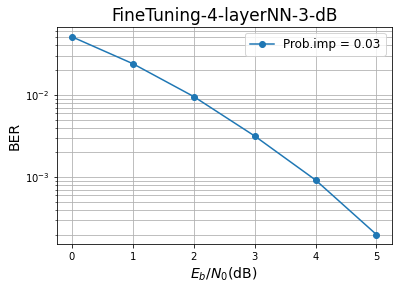

In [25]:
legend = []
# plt.plot(10*np.log10(1/(2*sigmas_map**2))-10*np.log10(k/N) , nb_errors_map/nb_bits_map, '-o')
# legend.append('MAP')

for p in range(0,len(impulse_probs)):
    # plt.plot(10*np.log10(1/(2*noise_sigmas**2)) -10*np.log10(k/N)-10*np.log10(np.log2(4)), BER[p], '-o')
    plt.plot(test_SNR_dB, BER[p], '-o')
    if (impulse_probs[p] == -1): legend.append("AWGN")
    else : legend.append("Prob.imp = "+ str(impulse_probs[p]))
    
plt.legend(legend, loc = 0, fontsize=12)
plt.yscale('log')
plt.ylabel('BER', fontsize=14) 
plt.xlabel('$E_b/N_0$(dB)', fontsize=14)
plt.title("FineTuning-4-layerNN-3-dB", fontsize=17)
# plt.grid(True, which="both")
plt.grid(True, which="both")
plt.rcParams['figure.figsize'] = (11, 7)
plt.show()
    
# Eb/N0 = 10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N) 
# Eb/N0 = symbols 能量 / 多少 bits = 平均每個 bits 的能量 
# BER : nb_errors/nb_bits